# Crop land cover

In [1]:
!pip install -q git+https://github.com/geopandas/dask-geopandas

In [2]:
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
from dask.distributed import Client

from pystac import Item
from pystac.extensions.item_assets import ItemAssetsExtension
import stackstac
import pyproj

import pystac_client
import planetary_computer as pc

warnings.filterwarnings(action="ignore", category=FutureWarning)

In [3]:
country = 'ZMB'
year = 2018
cell_size = 5000
geodetic_epsg = 'EPSG:4326'
projected_epsg = 'EPSG:20935' 

## Create grid and sample points to classify

In [4]:
africa = geopandas.read_file('data/africa_adm0.geojson')
boundary = africa[africa.adm0_a3 == country]

# world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# boundary = world.query('iso_a3 == "ZMB"')

boundary_prj = boundary.to_crs(projected_epsg)

xmin, ymin, xmax, ymax = boundary_prj.total_bounds

xs = list(np.arange(xmin, xmax + cell_size, cell_size))
ys = list(np.arange(ymin, ymax + cell_size, cell_size))
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = shapely.geometry.Polygon(ring).centroid
    return cell
cells = []
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        cells.append(cell)
        
grid = geopandas.GeoDataFrame({'geometry': cells}, crs = projected_epsg)
grid['lon'] = grid.geometry.x
grid['lat'] = grid.geometry.y
grid['x'] = grid.groupby(['lon']).ngroup() + 1
grid['y'] = grid.groupby(['lat']).ngroup() + 1
grid['includepoint'] = (grid.y + grid.x) % 2 == 0 
grid = grid[grid.includepoint]

# gdf = grid[grid.within(boundary_prj.unary_union)]
gdf = grid.copy()
gdf = gdf.to_crs(geodetic_epsg)
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y
gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
gdf.shape

(28270, 3)

In [5]:
NPARTITIONS = 250

ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd")

dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)

In [6]:
def query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull)

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )

    search_start = f"{year}-01-01"
    search_end = f"{year}-12-31"
    
    search = catalog.search(
        collections=["io-lulc-9-class"],
        intersects=intersects,
        # datetime=[search_start, search_end],
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "geometry": [],
    }

    index = []

    for item in features:
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = geopandas.GeoDataFrame(data, index=index, geometry="geometry")
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)

In [7]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

x = ia.item_assets["data"]
class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
values_to_classes = {v: k for k, v in class_names.items()}
class_count = len(class_names)
class_names

{'No Data': 0,
 'Water': 1,
 'Trees': 2,
 'Flooded vegetation': 4,
 'Crops': 5,
 'Built area': 7,
 'Bare ground': 8,
 'Snow/ice': 9,
 'Clouds': 10,
 'Rangeland': 11}

In [8]:
%%time

with Client(n_workers=16) as client:
    print(client.dashboard_link)
    meta = dgdf._meta.assign(stac_item=[])
    df2 = dgdf.map_partitions(query, meta=meta).compute()

/user/cullen.molitor@gmail.com/proxy/8787/status
CPU times: user 2.64 s, sys: 1.39 s, total: 4.02 s
Wall time: 21.3 s


In [9]:
df3 = df2.dropna(subset=["stac_item"]).reset_index()

matching_urls = [
    pc.sign(item["assets"]["data"]["href"]) for item in df3.stac_item.tolist()
]

points = df3[["lon", "lat"]].to_numpy()

In [20]:
class CustomDataset(Dataset):
    def __init__(self, points, fns, buffer=500):
        self.points = points
        self.fns = fns
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        fn = self.fns[idx]
        if lat < 0:
            if lon >= 6.0 and lon < 12.0:
                epsg = 32732
            elif lon >= 12.0 and lon < 18.0:
                epsg = 32733
            elif lon >= 18.0 and lon < 24.0:
                epsg = 32734
            elif lon >= 24.0 and lon < 30.0:
                epsg = 32735
            elif lon >= 30.0 and lon < 36.0:
                epsg = 32736
            elif lon >= 36.0 and lon < 42.0:
                epsg = 32737
            elif lon >= 42.0 and lon < 48.0:
                epsg = 32738
            else:
                epsg = 32739 
        else:
            pass
                    
        if fn is None:
            return None
        else:
            point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
            
             

            with rasterio.Env():
                with rasterio.open(fn, "r") as f:
                    point_geom = rasterio.warp.transform_geom(
                        "epsg:4326", 
                        epsg,
                        # projected_epsg,
                        # f.crs.to_string(), 
                        point_geom
                    )
                    point_shape = shapely.geometry.shape(point_geom)
                    mask_shape = point_shape.buffer(self.buffer).envelope
                    mask_geom = shapely.geometry.mapping(mask_shape)
                    try:
                        out_image, out_transform = rasterio.mask.mask(
                            f, [mask_geom], crop=True
                        )
                    except ValueError as e:
                        if "Input shapes do not overlap raster." in str(e):
                            return None

            out_image = out_image.squeeze()
            out_image = torch.from_numpy(out_image).float()
            return out_image
            # return f.crs

In [21]:
# dataset = CustomDataset(points, matching_urls)

In [22]:
# image = dataset[14737]
# image

In [23]:
dataset = CustomDataset(points, matching_urls)

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=os.cpu_count()*2,
    collate_fn=lambda x: x,
    pin_memory=False,
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
%%time
x_all = np.zeros((points.shape[0], 1), dtype=float)

tic = time.time()
i = 0
for images in dataloader:
    for image in images:

        if i % 10000 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()
        
        
        if type(image) == torch.Tensor:
            crops = (image == 5).sum() / image.numel()
            x_all[i] = crops.item()
        else:
            x_all[i] = float("NaN")
            
        i += 1

0/28270 -- 0.00% -- 0.44 seconds
10000/28270 -- 35.37% -- 14.61 seconds
20000/28270 -- 70.75% -- 14.43 seconds
CPU times: user 5.81 s, sys: 2.62 s, total: 8.43 s
Wall time: 41.6 s


In [25]:
crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
crops[["lon", "lat"]] = points.tolist()

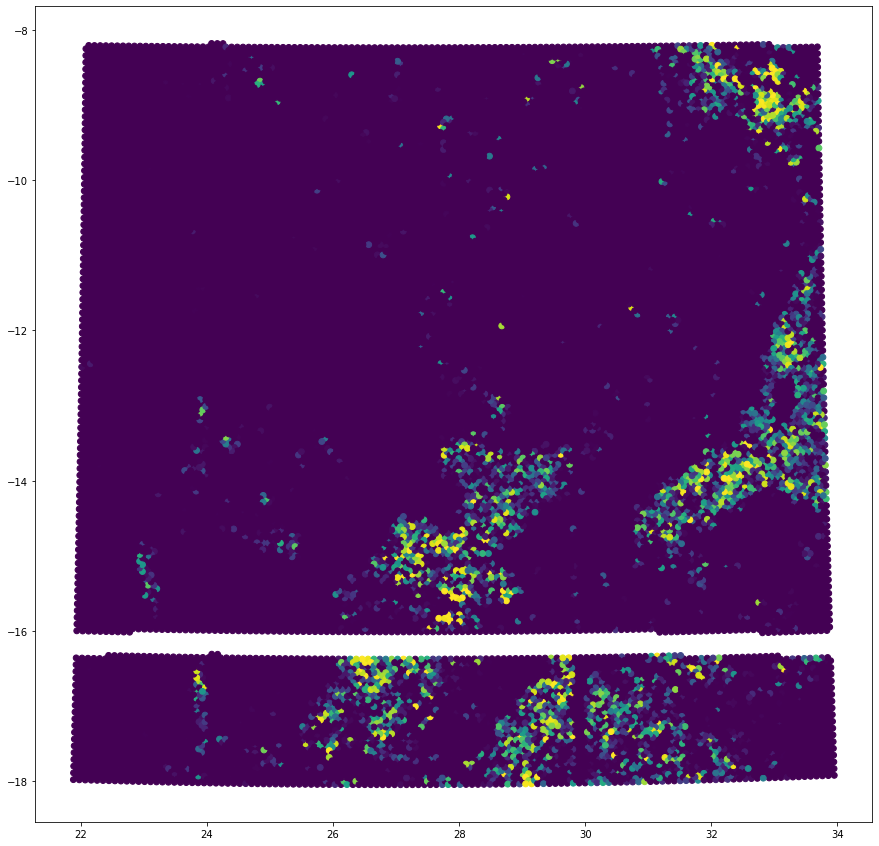

In [26]:
plt.figure(figsize = (15,15))
plt.scatter(crops.lon, crops.lat, c = crops.crop_perc, cmap = 'viridis', s = 34, alpha = 1)

In [17]:
#Save the crop_weights to a feather file
# file_name = f'data/{country}_crop_weights_{len(points)/1000:0.0f}k-points_{year}.feather'
# print("Saving file as:", file_name)
# crops.to_feather(file_name)
# print("Save finished!")